# Tratamiento de datos COVID-10
## Objeto
Se tratarán los datos de la [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19) que se traem al directorio $data_dir. 

Se utilizarán tablas de población para, en el futuro, obtener información más relevante

## Obtención de datos
Se obtienen los datos de población desde los repositorios de Naciones Unidas.
Los datos de contagios y fallecidos por COVID-19 se traen del repositorio mantenido por la Universidad Johns Hopkins, 
los de vacunaciones, de Our World In Data, los de medidas, del Centro Europeo para la Prevención y el Control de Enfermedades 
(una agencia de la UE),

In [412]:
data_dir = './data'
jhopkins_dir = 'COVID-19'
timeseries_dir = 'csse_covid_19_data/csse_covid_19_time_series'
covid_git_url = 'https://github.com/CSSEGISandData/COVID-19'
population_file = 'WPP2019_PopulationByAgeSex_Medium.csv'
covid_confirmed_file = 'time_series_covid19_confirmed_global.csv'
covid_deaths_file = 'time_series_covid19_deaths_global.csv'
un_pop_repo_url = 'https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/' + population_file
covid_owid_dir = 'covid-19-data'
covid_owid_url = 'https://github.com/owid/covid-19-data.git'
covid_owid_vaccinations_file = 'public/data/vaccinations/vaccinations.csv'
measures_file = 'measures.csv'

! if [ ! -d '{data_dir}' ]; then echo 'No existe directorio de datos. Creándolo...'; mkdir '{data_dir}' ; fi
! if [ ! -d '{data_dir}/{jhopkins_dir}/{timeseries_dir}' ]; then echo No existe clone del repositorio '{jhopkins_dir}/{timeseries_dir}' Ejecutando git clone '{covid_git_url}'; cd '{data_dir}';  git clone '{covid_git_url}'; fi
! if [ ! -d '{data_dir}/{covid_owid_dir}' ]; then echo 'No existe clone del repositorio {covid_owid_dir}. Ejecutando git clone {covid_owid_url}'; cd '{data_dir}';  git clone '{covid_owid_url}'; fi
! if [ ! -f '{data_dir}/{population_file}' ]; then echo 'No existen datos de población Trayéndolos de {un_pop_repo_url}'; cd '{data_dir}'; curl -g '{un_pop_repo_url}' -o $population_file; fi

### Datos de población

In [413]:
! ls -l '{data_dir}/{population_file}'

-rw-r--r-- 1 10001 10001 118543941 Feb  7  2021 ./data/WPP2019_PopulationByAgeSex_Medium.csv


### Datos de la Johns Hopkins

In [414]:
! cd '{data_dir}/{jhopkins_dir}' ; git pull
# ! cd '{data_dir}/{jhopkins_dir}' ; git checkout origin/master -- '{timeseries_dir}'
! ls -l '{data_dir}/{jhopkins_dir}/{timeseries_dir}/' 

remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (47/47), done.
remote: Total 90 (delta 47), reused 47 (delta 47), pack-reused 43
Unpacking objects: 100% (90/90), 3.95 MiB | 1.88 MiB/s, done.
From https://github.com/CSSEGISandData/COVID-19
   f2e8311ce0..64ed9af62d  master     -> origin/master
 * [new branch]            automated-patch-for-delayed-data-for-India-Pakistan-Mexico-02-04-2022 -> origin/automated-patch-for-delayed-data-for-India-Pakistan-Mexico-02-04-2022
 * [new branch]            automated-patch-for-delayed-data-for-US-02-04-2022 -> origin/automated-patch-for-delayed-data-for-US-02-04-2022
   57d5c847f0..4288bbd161  web-data   -> origin/web-data
Updating f2e8311ce0..64ed9af62d
Fast-forward
 .../csse_covid_19_daily_reports/02-04-2022.csv     | 4007 ++++++++++++
 .../csse_covid_19_daily_reports_us/02-04-2022.csv  |   59 +
 .../time_series_covid19_confirmed_US.csv           | 6686 ++++++++++----------
 .../time_series_covid19_confirmed_global.csv       |

### Datos de Our World In Data 

In [415]:
! cd '{data_dir}/{covid_owid_dir}'; git pull
! ls -l '{data_dir}/{covid_owid_dir}/{covid_owid_vaccinations_file}'

remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 114 (delta 78), reused 114 (delta 78), pack-reused 0
Receiving objects: 100% (114/114), 4.47 MiB | 8.55 MiB/s, done.
Resolving deltas: 100% (78/78), completed with 26 local objects.
From https://github.com/owid/covid-19-data
   130c172973..0efd07d9ac  master     -> origin/master
Updating 130c172973..0efd07d9ac
Fast-forward
 .../hospitalizations/covid-hospitalizations.csv    | 764 +++++++++++----------
 public/data/hospitalizations/locations.csv         |  16 +-
 public/data/internal/megafile--all-reduced.json    |   2 +-
 public/data/internal/megafile--auxiliary.json      |   2 +-
 public/data/internal/megafile--cases-tests.json    |   2 +-
 public/data/internal/megafile--deaths.json         |   2 +-
 .../internal/megafile--hospital-admissions.json    |   2 +-
 ...owid-covid-data-last-updated-timestamp-hosp.txt |   2 +-
 ...owid-covid-da

### Datos de medidas tomadas

In [416]:
! curl 'https://www.ecdc.europa.eu/sites/default/files/documents/response_graphs_data_2021-01-28.csv' >> $data_dir/$measures_file
! ls -l $data_dir/$measures_file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75391  100 75391    0     0   404k      0 --:--:-- --:--:-- --:--:--  402k
-rw-r--r-- 1 10001 10001 46817811 Feb  5 09:27 ./data/measures.csv


### Importación de datos
Lo primero es común a todos los programas que traten datos

In [417]:
%matplotlib inline
import pandas as pd
import numpy as np

Se utiliza Pandas para leer el fichero csv. Las columnas que notienen datos (las 4 primeras), se ponen de índice. 

Se van a leer los datos de fallecimientos, casos confirmados, población y vacunaciones.

Los datos de medidas, hasta que no se optimice el procedimiento, se obtienen después

In [418]:
deaths = pd.read_csv(data_dir + '/' + jhopkins_dir + '/' +  timeseries_dir + '/' + covid_deaths_file, 
                      index_col=[0,1,2,3])
confirmed = pd.read_csv(data_dir + '/' + jhopkins_dir + '/' +  timeseries_dir + '/' + covid_confirmed_file, 
                           index_col=[0,1,2,3])
population = pd.read_csv (data_dir + '/' + population_file)
vaccinations = pd.read_csv (data_dir + '/' + covid_owid_dir + '/' + covid_owid_vaccinations_file, 
                            usecols=['location', 'date',
                                     'people_vaccinated_per_hundred',
                                     'people_fully_vaccinated_per_hundred',
                                     'total_boosters_per_hundred'], 
                            parse_dates=['date'])
# deaths.head(3)
vaccinations.groupby('location').get_group('Spain').tail(10)

,location,date,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred
67809,Spain,2022-01-24,87.33,81.83,42.76
67810,Spain,2022-01-25,87.39,81.86,43.56
67811,Spain,2022-01-26,87.43,81.88,44.20
67812,Spain,2022-01-27,87.46,81.90,44.82
67813,Spain,2022-01-28,NaN,NaN,NaN
67814,Spain,2022-01-29,NaN,NaN,NaN
67815,Spain,2022-01-30,87.52,81.91,45.98
67816,Spain,2022-01-31,87.54,81.92,46.35
67817,Spain,2022-02-01,87.55,81.94,46.89
67818,Spain,2022-02-02,87.57,81.96,47.29


## Tratamiento de datos
Se filtran los datos de población para suprimir la división por edades y quedarnos con los del año 2021. 
Se conserva la división por género por si tuviese interés

In [419]:
pop_filtered = population[(population['VarID'] == 2) & (population['Time'] == 2021) ] \
                         [['Location','PopMale','PopFemale','PopTotal']] \
                         .groupby(['Location']).sum()

#population.head()
#pop_filtered.index.names

pop_filtered.loc['South Africa']
#pop_filtered.head(3)

PopMale      29564.652
PopFemale    30477.344
PopTotal     60041.996
Name: South Africa, dtype: float64

Se cambia el nombre de algunos índices. Se ha visto que el nombre de los países es distinto en las tablas de la 
ONU que en las tablas COVID. Por ejemplo, los **Estados Unidos de América** aparecen en las tablas de la ONU
como **United States of America**, mientras que en las tablas COVID como **US**. El diccionario **change_dict**
está pensado para todos estos casos.

In [420]:
change_pop_dict = {
    'United States of America': 'US',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Russian Federation': 'Russia',
    'China, Taiwan Province of China': 'Taiwan*'
              }

pop_index_list = pop_filtered.index.tolist()

for country in change_pop_dict:
    pop_index_list[pop_index_list.index(country)] = change_pop_dict[country]

pop_filtered.index = pop_index_list

In [421]:
pop_filtered.loc[['US',
                  'Spain',
                  'Portugal',
                  'Morocco',
                  'United Kingdom',
                  'Ireland',
                  'Italy',
                  'Germany',
                  'France',
                  'Argentina',
                  'Chile',
                  'Mexico',
                  'Peru',
                  'Colombia', 
                  'Venezuela', 
                  'Cuba', 
                  'Bolivia', 
                  'Ecuador', 
                  'Guatemala', 
                  'Panama', 
                  'Costa Rica',
                  'Russia',
                  'China',
                  'Taiwan*',
                  'Belgium',
                  'Netherlands',
                  'Australia',
                  'Israel',
                  'India',
                  'South Africa',
                  'Japan',
                  'Angola',
                  'Algeria',
                  'Egypt',
                  'Turkey',
                 ]].sort_values('PopTotal', ascending=False)

,PopMale,PopFemale,PopTotal
China,740521.760,703694.342,1444216.102
India,723973.437,669435.596,1393409.033
US,164729.431,168185.643,332915.074
Russia,67638.243,78273.779,145912.022
Mexico,63724.708,66537.512,130262.220
Japan,61534.563,64516.233,126050.796
Egypt,52672.373,51585.954,104258.327
Turkey,41984.498,43058.238,85042.736
Germany,41500.151,42400.320,83900.471
United Kingdom,33716.291,34490.823,68207.114


Se obtienen los dataframes de incrementos por población

In [422]:
deaths_sum = deaths.groupby(level=1).sum()
confirmed_sum = confirmed.groupby(level=1).sum()


def get_by_pop_inc_df (df,pop):
    df_by_pop_inc = df.divide(pop_filtered['PopTotal']/(pop/1000), axis=0).transpose().diff()
    df_by_pop_inc.index = pd.to_datetime(df_by_pop_inc.index)
    return df_by_pop_inc
    
confirmed_factor = 100000
deaths_factor = 10000000
confirmed_sum_by_pop_inc = get_by_pop_inc_df(confirmed_sum,confirmed_factor)
deaths_sum_by_pop_inc = get_by_pop_inc_df(deaths_sum,deaths_factor)


#confirmed_sum_by_pop_inc.head(3)
#confirmed_100K = confirmed_sum.loc['Spain'].diff() / (pop_filtered.loc['Spain']['PopTotal'] /100)
#confirmed_100K.rolling(min_periods=1, window=7).sum().tail(35)






## Gráficos

Se obtienen gráficos para fallecimientos y casos confirmados utilizando ventanas deslizantes de
longitud variable (**confirmed_window** y **deaths_window**) para casos confirmados y fallecimientos.
Se ha comprobadoque los datos presentan fuerte correlación con el día de la semana. Por elllo,
Cualquier longitud de ventana que no sea múltiplo de 7 causa dientes de sierra.

Los países para los cuales se desean los gráficos están en el array **interesting_countries**.

El último dato es el de la fecha en la que se ejecuta el notebook (**todate = today**). El primero de 
los datos es el de hace **nweeks** (configurable) semanas.

La escala en y puede ser logarítimca (**logaritmic = True**) o no (**logaritmic = False**).

El tamaño del gráfico se configura con **fsize**. Se trata de una dupla en el que el primer
componente es el tamaño del eje x y el segundo el del eje y.


In [423]:
import datetime as dt

nweeks=12
interesting_countries = [
                         'Spain',
                         'United Kingdom', 
                         #'Denmark',
                         #'Ireland', 
                         'Portugal',  
                         #'Israel',
                         'France', 
                         'Germany',
#                          'Italy',
#                          'Netherlands',
#                          'Austria',
#                          'Belgium',
#                          'Sweden',
#                          'Norway',
#                          'Denmark',
#                          'Poland',
                         'US',
                         #'Chile',
                         #'Argentina',
                         #'Venezuela',
                         #'Japan',
#                          'Canada',
#                          'Australia',
                         #'Mexico',
                         #'Colombia',
                         #'Peru',
                         #'Morocco',
                         #'India',
                         #'Russia',
#                          'South Africa',
                         #'Angola',
                         #'Egypt',
                         #'Romania',
                         #'Bulgaria',
#                         'Uganda',
                        ]

today = dt.date.today()
#yesterday = today - dt.timedelta(days=1)
fsize=(20,15)
confirmed_window = 14
deaths_window = 14
# fromdate=today - dt.timedelta(weeks=nweeks, days=max(confirmed_window, deaths_window))
fromdate=today - dt.timedelta(weeks=nweeks)

todate=today
#fsize=(10,5)
#fromdate = dt.datetime(2020,3,13)
#todate = dt.datetime(2020,4,3)
logaritmic= False


fromdate_df = fromdate - dt.timedelta(days=max(confirmed_window, deaths_window))

# deaths_sum_df = deaths_sum
# deaths_sum_df.columns = pd.to_datetime(deaths_sum_df.columns)
# deaths_sum_df.loc[['Spain','Italy','United Kingdom','Germany','Portugal']]


Cálculo de la letalidad

In [424]:
d2c_average = 12
days_to_sum = 7
lethality_factor = 100000

def ser_diff (ser, country, from_date, to_date):
    return ser.loc[country][to_date.strftime('%-m/%-d/%y')] - \
           ser.loc[country][from_date.strftime('%-m/%-d/%y')]
today = dt.date.today()


def calc_lethality (day, country, window, d2c=d2c_average):
    tdd = day
    fdd = tdd - dt.timedelta(days=window)
    tdc = tdd - dt.timedelta(days=d2c)
    fdc = tdc - dt.timedelta(days=window)
    ndeaths = ser_diff(deaths_sum, country, fdd, tdd)
    nconfirmed = ser_diff(confirmed_sum, country, fdc, tdc)
    if (nconfirmed <= 0):
        return 0
    elif (ndeaths <= 0):
        return 0
    elif (ndeaths/nconfirmed >= 10):
        return 10
    return ndeaths/nconfirmed

# to_date_deaths = today - dt.timedelta(days=2)
# from_date_deaths = to_date_deaths - dt.timedelta(days=days_to_sum)
# to_date_confirmed = to_date_deaths - dt.timedelta(days=d2c_average)
# from_date_confirmed = from_date_deaths - dt.timedelta(days=d2c_average)

# for country in interesting_countries:
#     npopulation = round(pop_filtered['PopTotal'][country]*1000)
#     ndeaths = ser_diff(deaths_sum, country, from_date_deaths, to_date_deaths)
#     nconfirmed = ser_diff(confirmed_sum, country, from_date_confirmed, to_date_confirmed)
#     print ("{} - Población: {} - Casos {} - Fallecimientos {} - Letalidad {:.2%}".format(country, 
#                                                                        npopulation,
#                                                                        nconfirmed,
#                                                                        ndeaths,
#                                                                        ndeaths/nconfirmed))

lethal_df_size_days = 7*nweeks
to_date_lethal = today - dt.timedelta(days=2)

dates=[]
for i in range(lethal_df_size_days):
    let_date = to_date_lethal - dt.timedelta(days=lethal_df_size_days -1 -i)
    dates.append(let_date)
lethality = pd.DataFrame(index= dates)

for country in interesting_countries:
    values = []
    for i in range(lethal_df_size_days):
        let_date = to_date_lethal - dt.timedelta(days=lethal_df_size_days -1 -i)
        let_value = calc_lethality(let_date,
                                   country, 
                                   days_to_sum, 
                                   d2c_average)*lethality_factor
        values.append(let_value)
    lethality[country] = values

# lethality['Spain']

Los primeros gráficos son comparativos entre países. Permiten ver la evolución de la enfermedad
en distintos entornos

<AxesSubplot:title={'center':'Letalidad por 100000 infectados'}>

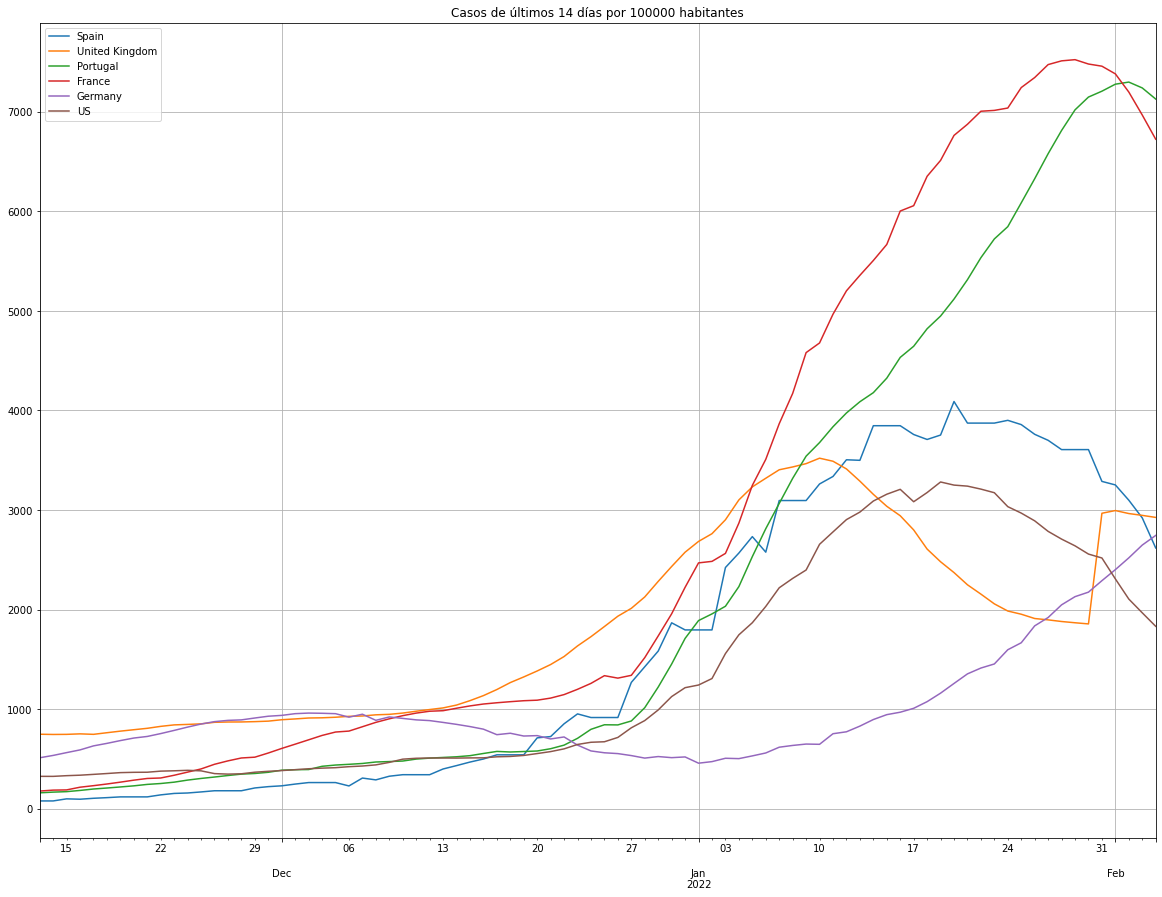

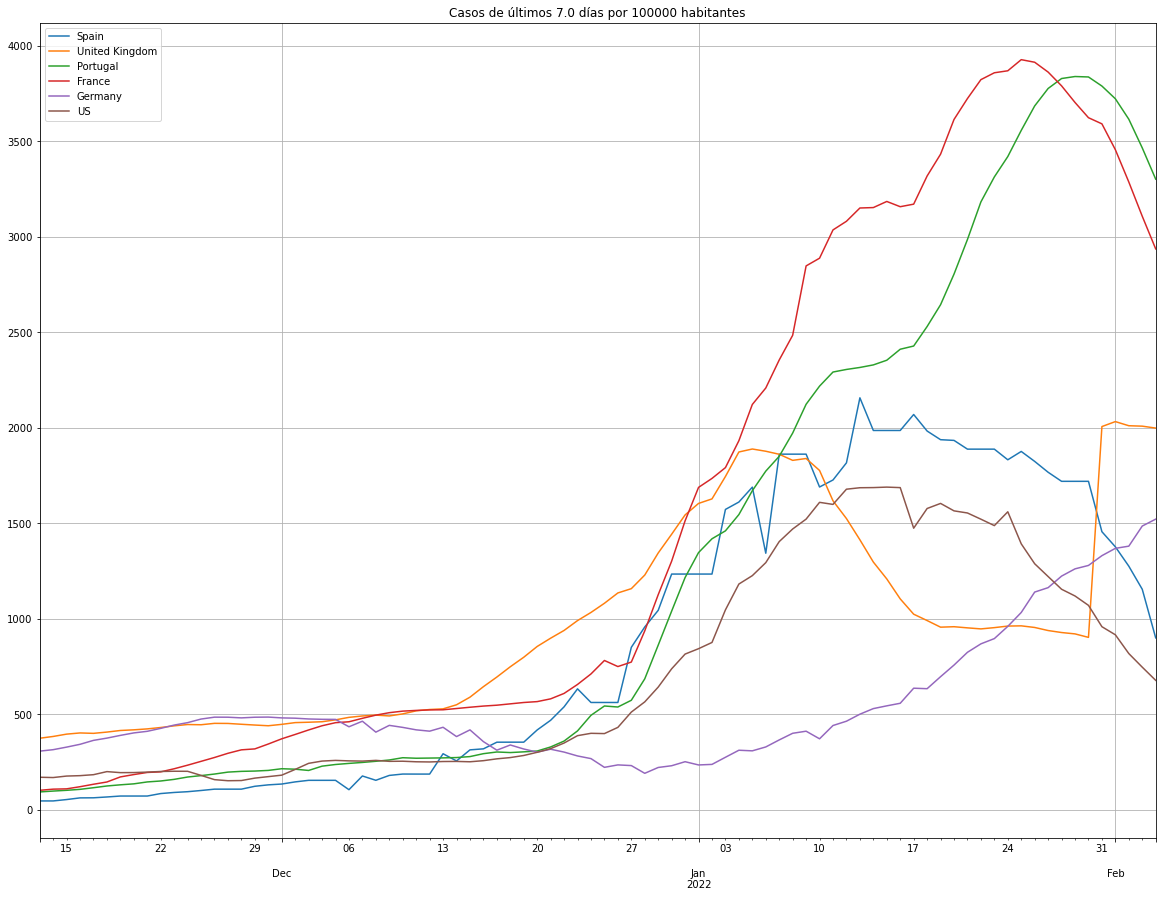

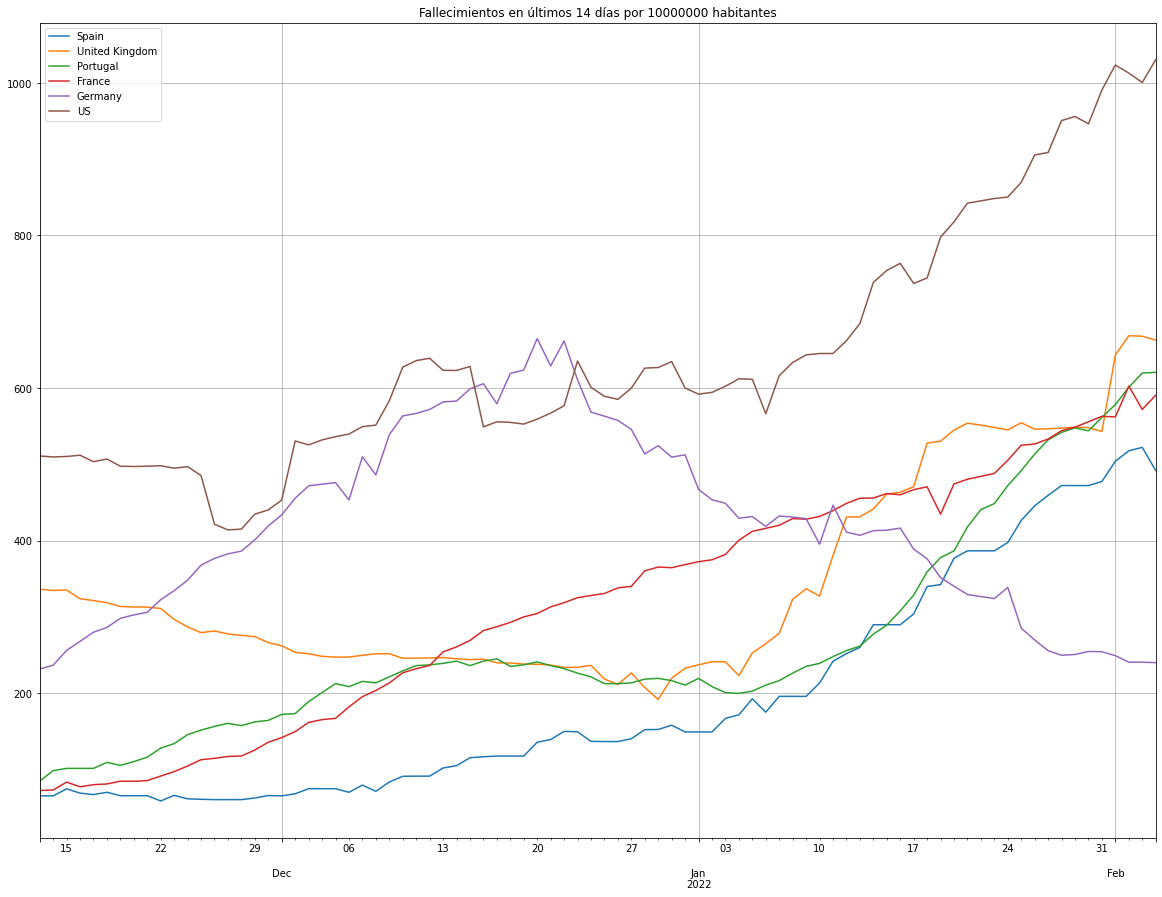

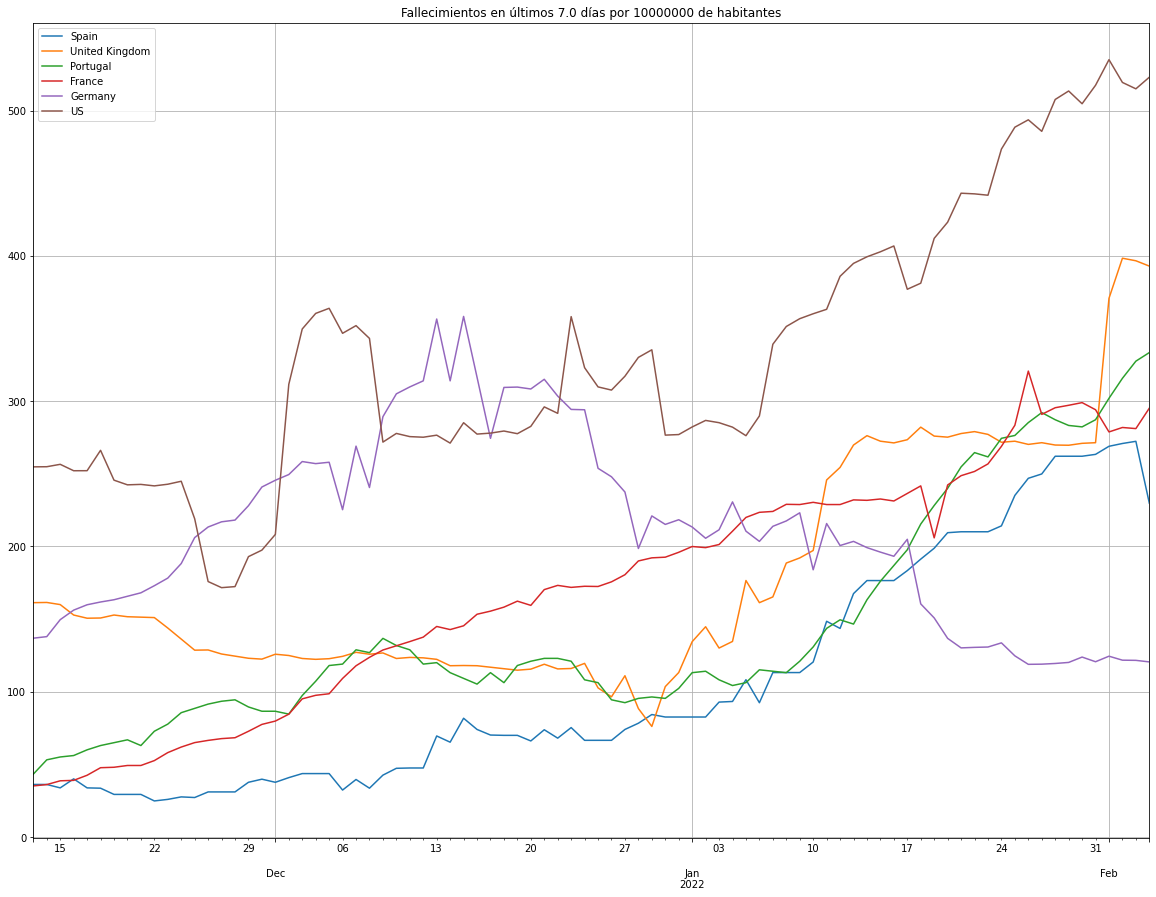

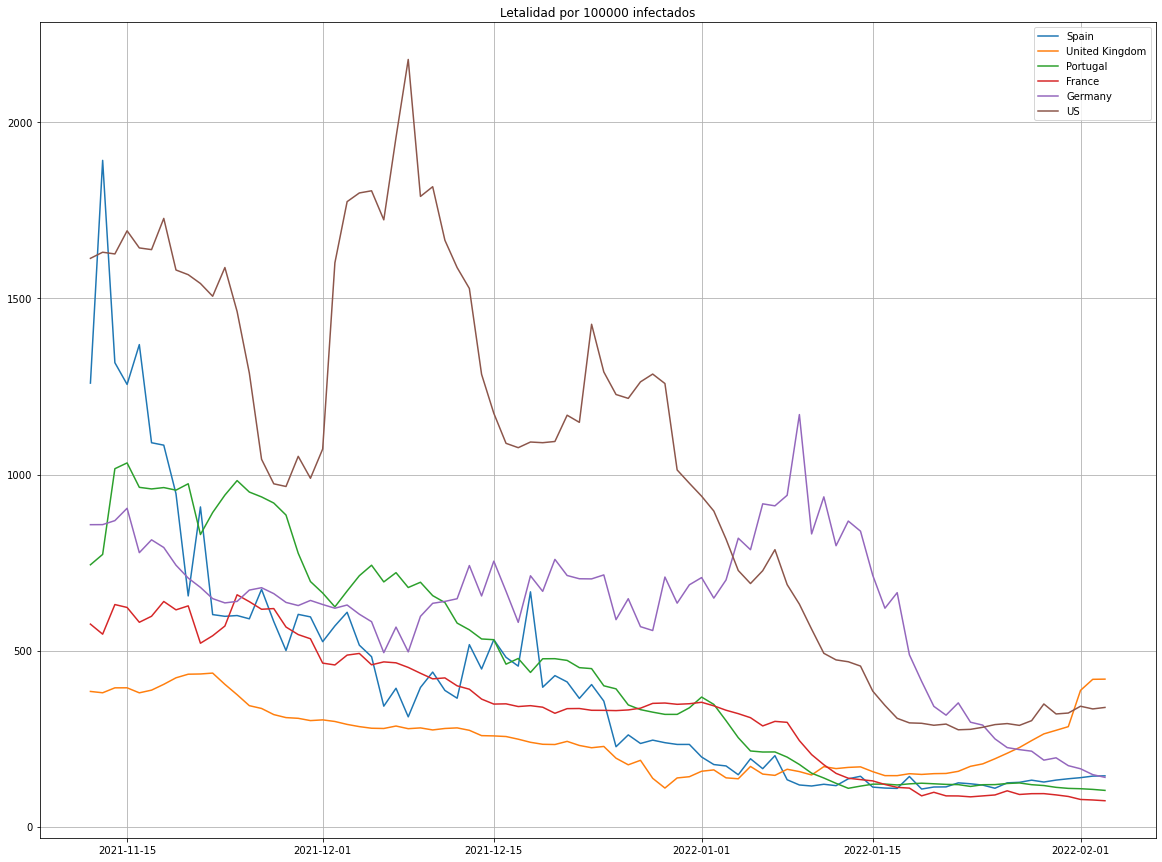

In [425]:
cw_df = confirmed_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=confirmed_window).sum()[interesting_countries]
cw_df[fromdate:todate].plot(
                            title='Casos de últimos {} días por {} habitantes'.format(confirmed_window, confirmed_factor), 
                            figsize=fsize, 
                            logy=logaritmic,
                            grid=True
                           )

cw2_df = confirmed_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=int(confirmed_window/2)).sum()[interesting_countries]
cw2_df[fromdate:todate].plot(
                             title='Casos de últimos {} días por {} habitantes'.format(confirmed_window/2, confirmed_factor), 
                             figsize=fsize, 
                             logy=logaritmic,
                             grid=True
                            )
dw_df = deaths_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=deaths_window).sum()[interesting_countries]
dw_df[fromdate:todate].plot(
                            title='Fallecimientos en últimos {} días por {} habitantes'.format(deaths_window, deaths_factor), 
                            figsize=fsize, 
                            logy=logaritmic,
                            grid=True
                           )
dw2_df = deaths_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=int(deaths_window/2)).sum()[interesting_countries]
dw2_df[fromdate:todate].plot(
                             title='Fallecimientos en últimos {} días por {} de habitantes'.format(deaths_window/2, deaths_factor), 
                             figsize=fsize, 
                             logy=logaritmic,
                             grid=True
                            )

lethality.plot(
               title='Letalidad por {} infectados'.format(lethality_factor),
               figsize = fsize,
               logy=logaritmic,
#                ylim=(0,2000),
               grid=True
               )

Curvas de vacunación

In [426]:
vac_grouped = vaccinations.groupby('location')

vacitems_suffixes = {
    'people_vaccinated_per_hundred': ' people',
    'people_fully_vaccinated_per_hundred': ' fully',
    'total_boosters_per_hundred': ' boosters',
}

# Utilizamos los nombres de países de la Johns Hopkins.
# Creamos, para ello, un diccionario que traduce el nombre del país en los datos
# de vacunaciones al nombre en los datos de la Johns Hopkins

change_vac_countries = {
    'US': 'United States'
}

change_vac_dict = {}
for k in change_vac_countries.keys():
    for suffix in vacitems_suffixes.values():
        change_vac_dict[k + suffix] = change_vac_countries[k] + suffix

# Creamos un nuevo dataframe iterando sobre todos los países en grouped,
# añadiendo, para cada país, tantas columnas como líneas hay en el diccionario
# vacitems_suffixes utilizando, en lugar del nombre de la clave, el del país seguido por
# el sufijo correspondiente.

vc_df = pd.DataFrame()
        

interesting_vac_renamed_countries = []
for country in interesting_countries:
    if country in change_vac_countries.keys():
        vcname = change_vac_countries[country]
    else:
        vcname = country
 
    if vcname in vac_grouped.groups:
        interesting_vac_renamed_countries.append((country,vcname))

        vacgr_df = vac_grouped.get_group(vcname).set_index('date')

        for item in vacitems_suffixes.keys():
            vc_df[country + vacitems_suffixes[item]] = vacgr_df[item]
        

vc_df.fillna(method='ffill',inplace=True)

#vc_df.fillna(0.0, inplace=True)total_boost
vc_df

,Spain people,Spain fully,Spain boosters,United Kingdom people,United Kingdom fully,United Kingdom boosters,Portugal people,Portugal fully,Portugal boosters,France people,France fully,France boosters,Germany people,Germany fully,Germany boosters,US people,US fully,US boosters
date,,,,,,,,,,,,,,,,,,
2021-01-04,0.18,NaN,NaN,NaN,NaN,NaN,0.33,NaN,NaN,0.01,NaN,NaN,0.42,0.00,0.00,1.98,0.03,NaN
2021-01-05,0.30,NaN,NaN,NaN,NaN,NaN,0.46,NaN,NaN,0.02,NaN,NaN,0.48,0.00,0.00,2.19,0.06,NaN
2021-01-06,0.30,NaN,NaN,NaN,NaN,NaN,0.60,NaN,NaN,0.04,NaN,NaN,0.55,0.00,0.00,2.44,0.11,NaN
2021-01-07,0.44,NaN,NaN,NaN,NaN,NaN,0.71,NaN,NaN,0.08,NaN,NaN,0.62,0.00,0.00,2.70,0.19,NaN
2021-01-08,0.59,NaN,NaN,NaN,NaN,NaN,0.73,NaN,NaN,0.13,NaN,NaN,0.69,0.00,0.00,2.96,0.30,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-29,87.46,81.90,44.82,76.73,70.94,54.64,94.19,90.45,48.34,79.76,76.31,47.99,75.10,73.32,52.39,75.38,63.63,26.59
2022-01-30,87.52,81.91,45.98,76.74,70.98,54.69,94.19,90.47,49.17,79.76,76.33,48.04,75.11,73.34,52.44,75.40,63.65,26.63
2022-01-31,87.54,81.92,46.35,76.77,71.02,54.75,94.19,90.49,49.83,79.78,76.39,48.26,75.14,73.40,52.64,75.45,63.69,26.70


<AxesSubplot:title={'center':'Vacunaciones (%)'}, xlabel='date'>

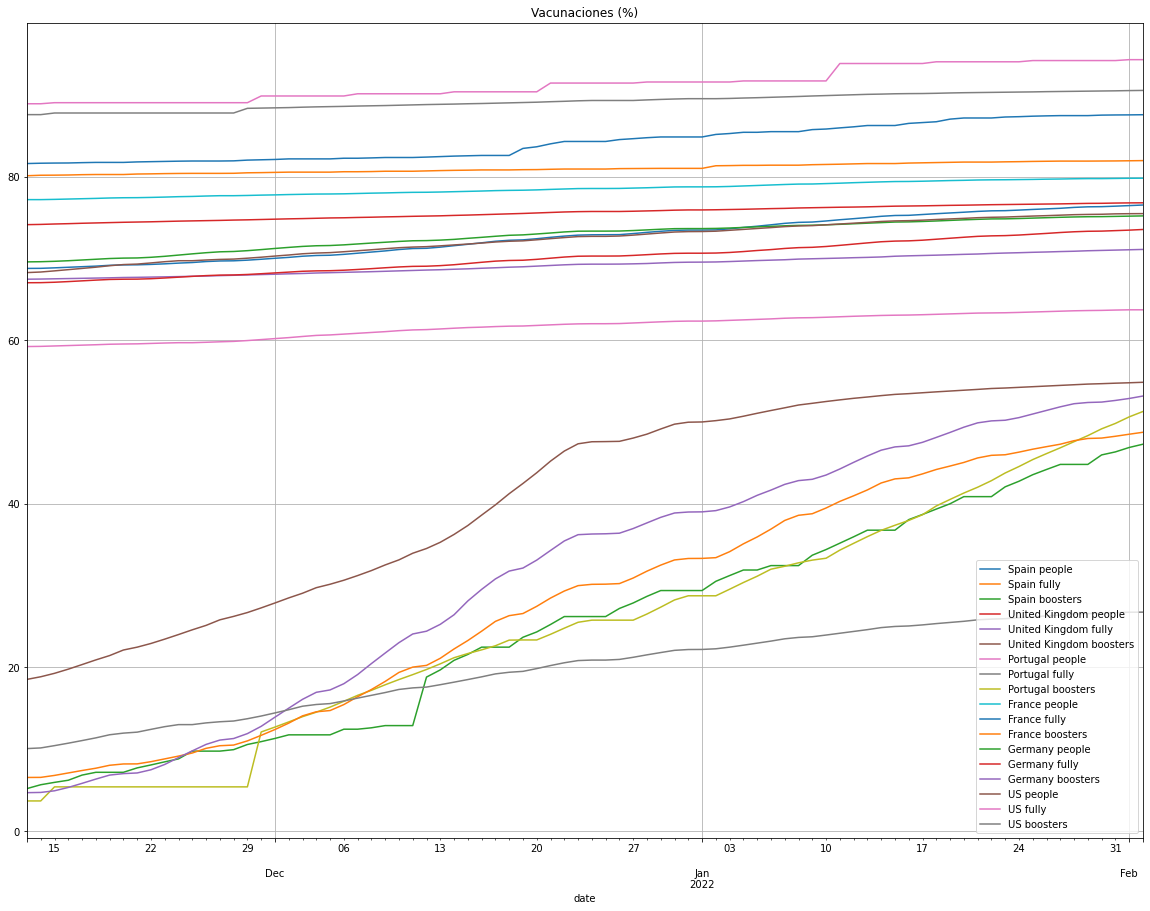

In [427]:
#vc_df [['Spain people', 'Spain fully']]

vc_labels = []
for i in interesting_vac_renamed_countries:
    for suffix in vacitems_suffixes.values():
        vc_labels.append(i[0] + suffix)

vc_df_toplot = vc_df[vc_labels]
    
vc_df_toplot[fromdate:todate].plot(
                      title='Vacunaciones (%)', 
                      figsize=fsize, 
                      logy=False,
                      grid=True
                     )

Los siguientes gráficos muestran los casos confirmados y fallecimientos por cada país.

Los casos confirmados en las ventanas pequeñas son predictores de los casos confirmados en
ventanas más grandes y ambos son predictores del número de fallecimientos

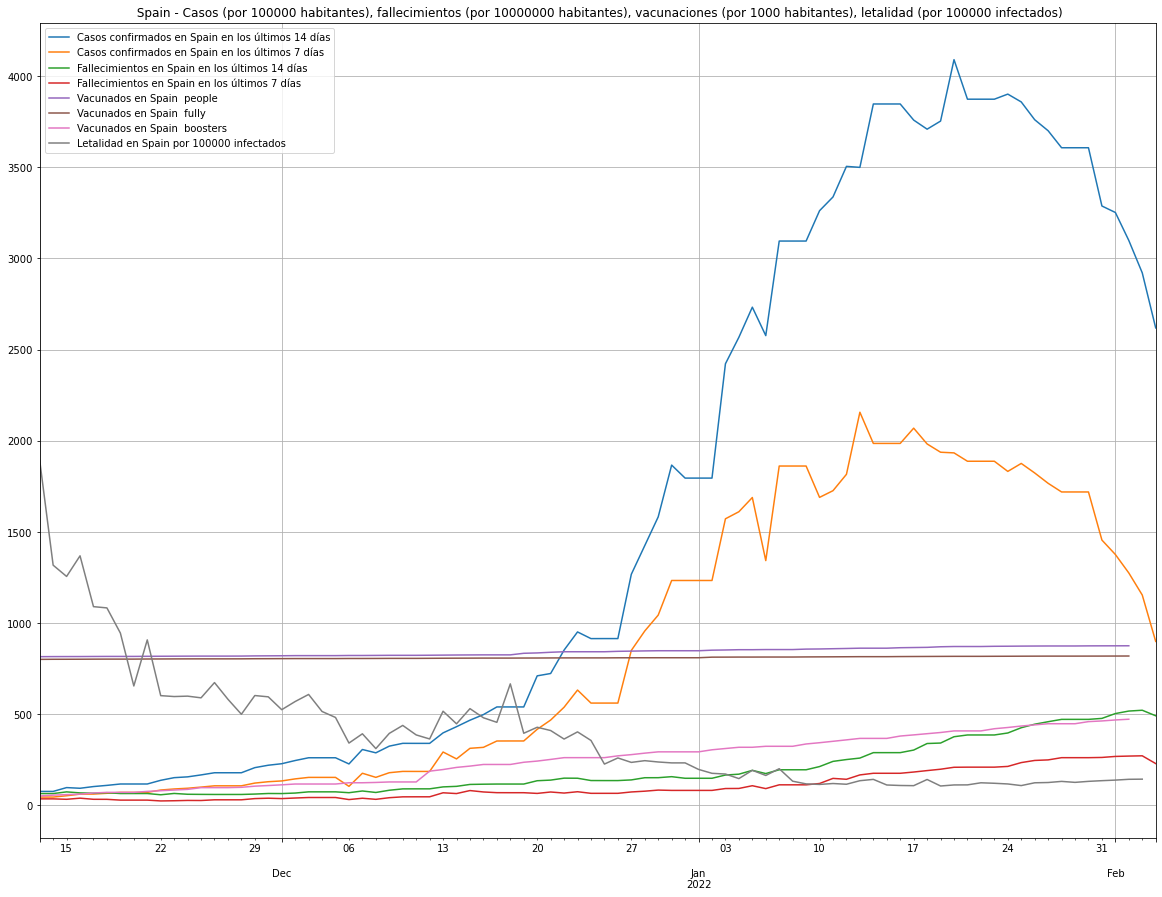

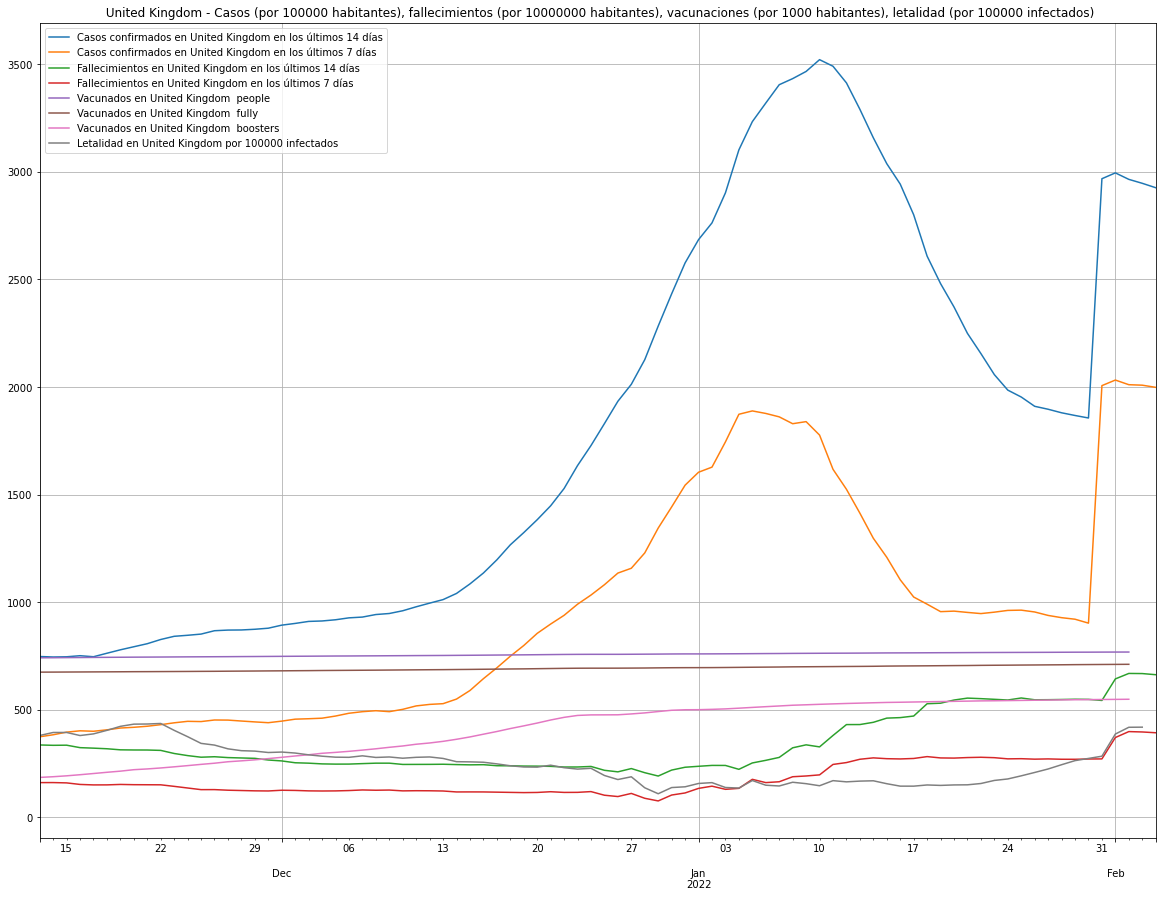

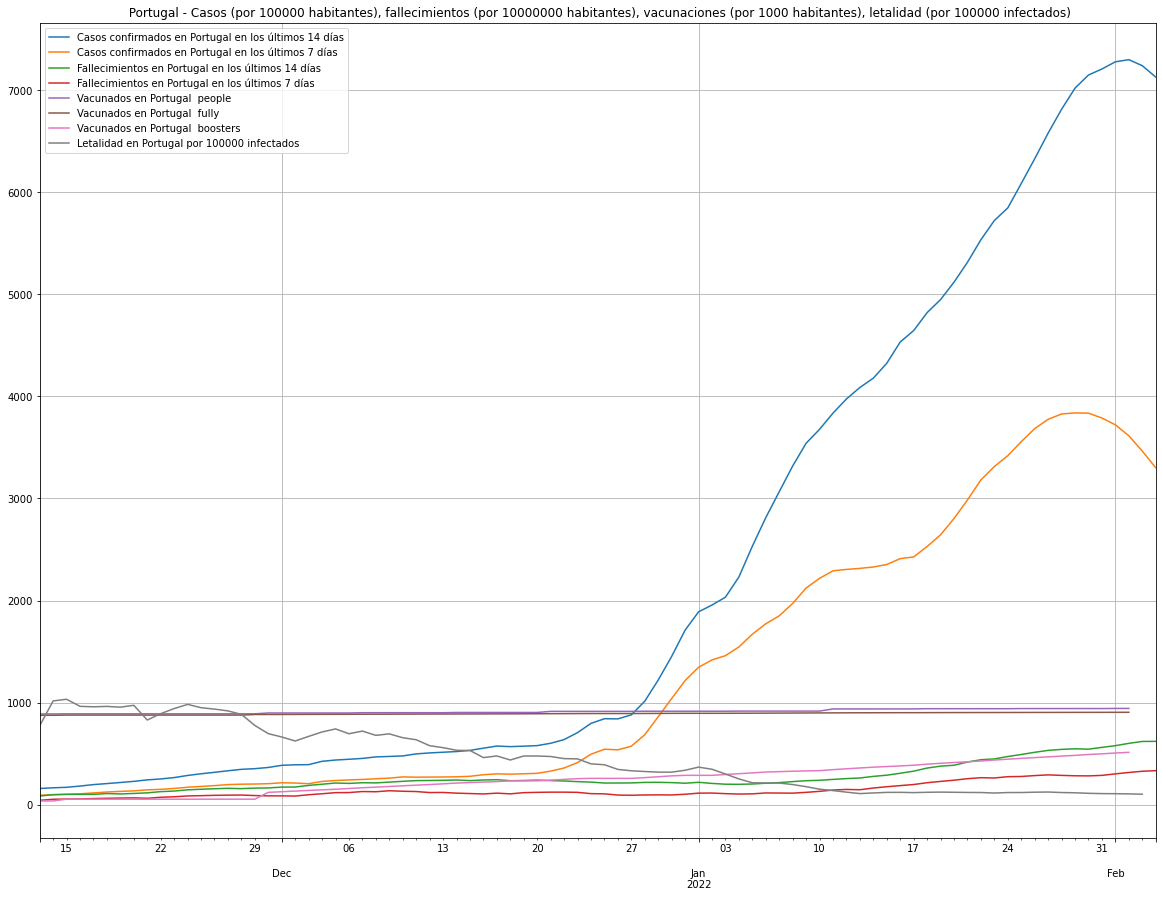

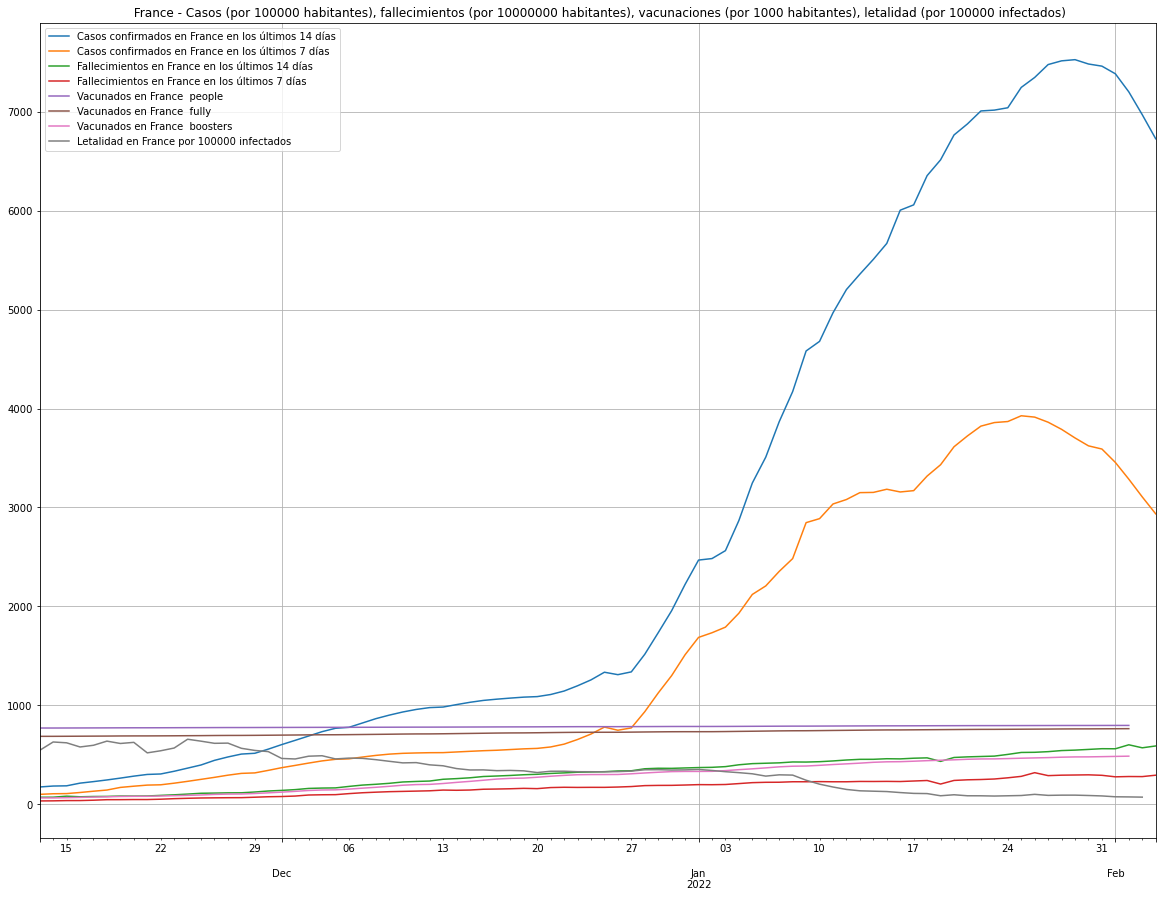

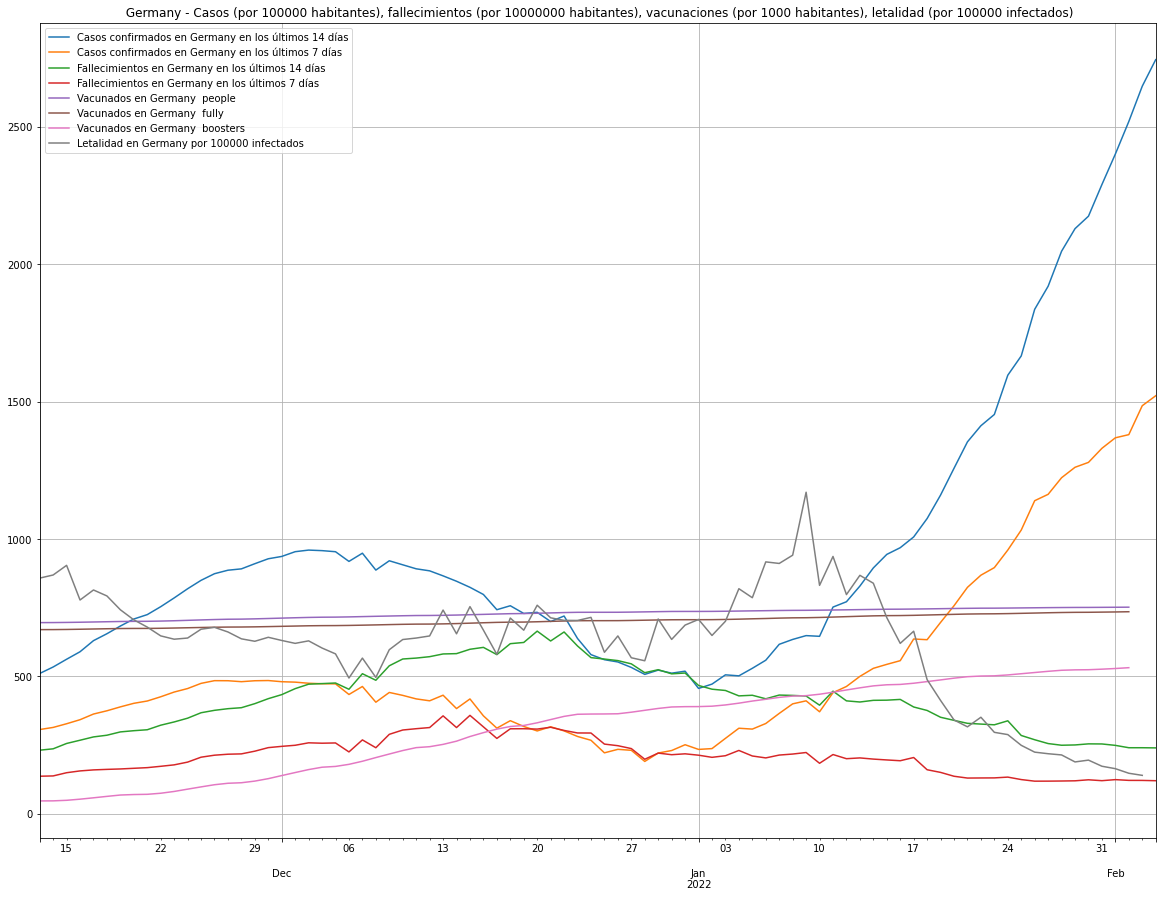

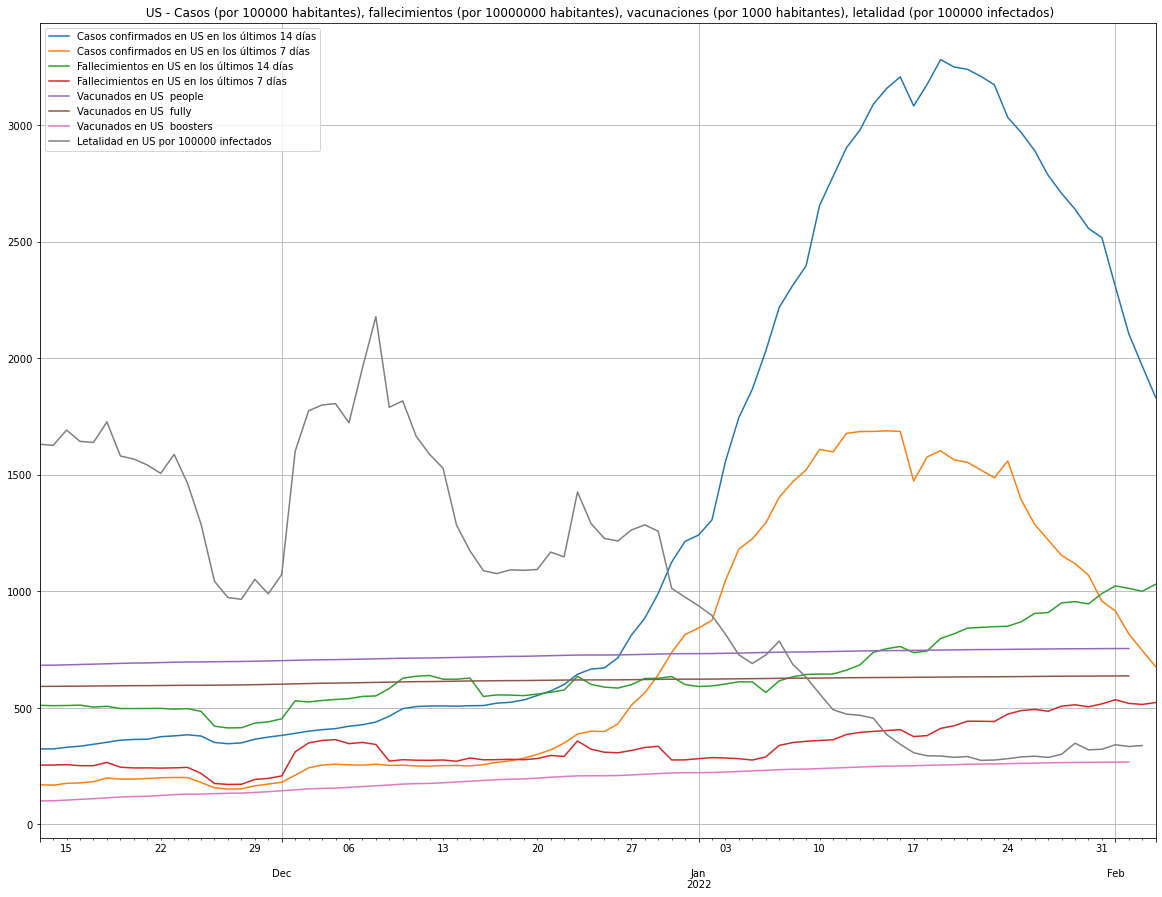

In [428]:
for ic in interesting_countries:
    country_df = pd.DataFrame()
    country_df['Casos confirmados en {} en los últimos {} días'.format(ic,str(confirmed_window))] = cw_df[ic]
    country_df['Casos confirmados en {} en los últimos {} días'.format(ic,str(int(confirmed_window/2)))] = cw2_df[ic]
    country_df['Fallecimientos en {} en los últimos {} días'.format(ic,str(confirmed_window))] = dw_df[ic]
    country_df['Fallecimientos en {} en los últimos {} días'.format(ic,str(int(confirmed_window/2)))] = dw2_df[ic]
#     if ic + vacitems_suffixes['people_fully_vaccinated_per_hundred'] in vc_df:
#         country_df['Vacunados completamente por mil habitantes']= vc_df[ ic + vacitems_suffixes['people_fully_vaccinated_per_hundred']]*10
#     if ic + vacitems_suffixes['people_vaccinated_per_hundred'] in vc_df:
#         country_df['Vacunados por mil habitantes']= vc_df[ic + vacitems_suffixes['people_vaccinated_per_hundred']]*10
    for suffix in vacitems_suffixes.values():
        country_df[f'Vacunados en {ic} {suffix}'] = vc_df [ic + suffix]*10

    country_df['Letalidad en {} por {} infectados'.format(ic,lethality_factor)] = lethality[ic]
 
    country_df[fromdate:todate].plot(
                   title= ' {} - '.format(ic) +
                         'Casos (por {} habitantes), '.format(confirmed_factor) +
                         'fallecimientos (por {} habitantes), '.format(deaths_factor) + 
                         'vacunaciones (por {} habitantes), '.format(1000) +
                         'letalidad (por {} infectados)'.format(lethality_factor),
                   figsize=fsize, 
                   logy=False,
#                    ylim=(0,5000),
                   grid=True
    )


In [429]:
# d2c_average = 24
# days_to_sum = 14

# def ser_diff (ser, country, from_date, to_date):
#     return ser.loc[country][to_date.strftime('%-m/%-d/%y')] - \
#            ser.loc[country][from_date.strftime('%-m/%-d/%y')]
# today = dt.date.today()


# def calc_lethality (day, country, window, d2c=d2c_average):
#     tdd = day
#     fdd = tdd - dt.timedelta(days=window)
#     tdc = tdd - dt.timedelta(days=d2c)
#     fdc = tdc - dt.timedelta(days=window)
#     ndeaths = ser_diff(deaths_sum, country, fdd, tdd)
#     nconfirmed = ser_diff(confirmed_sum, country, fdc, tdc)Kahootjmrobles

#     if (nconfirmed <= 0):
#         return 0
#     elif (ndeaths <= 0):
#         return 0
#     elif (ndeaths/nconfirmed >= 10):
#         return 10
#     return ndeaths/nconfirmed

# # to_date_deaths = today - dt.timedelta(days=2)
# # from_date_deaths = to_date_deaths - dt.timedelta(days=days_to_sum)
# # to_date_confirmed = to_date_deaths - dt.timedelta(days=d2c_average)
# # from_date_confirmed = from_date_deaths - dt.timedelta(days=d2c_average)

# # for country in interesting_countries:
# #     npopulation = round(pop_filtered['PopTotal'][country]*1000)
# #     ndeaths = ser_diff(deaths_sum, country, from_date_deaths, to_date_deaths)
# #     nconfirmed = ser_diff(confirmed_sum, country, from_date_confirmed, to_date_confirmed)
# #     print ("{} - Población: {} - Casos {} - Fallecimientos {} - Letalidad {:.2%}".format(country, 
# #                                                                        npopulation,
# #                                                                        nconfirmed,
# #                                                                        ndeaths,
# #                                                                        ndeaths/nconfirmed))

# #lethal_df_size_days = 7*nweeks
# lethal_df_size_days = 240   

# to_date_lethal = today - dt.timedelta(days=2)

# dates=[]
# for i in range(lethal_df_size_days):
#     let_date = to_date_lethal - dt.timedelta(days=lethal_df_size_days -1 -i)
#     dates.append(let_date)
# lethality = pd.DataFrame(index= dates)

# days = range(7,35)



# for country in interesting_countries:
#     values = []
#     for i in range(lethal_df_size_days):
#         let_date = to_date_lethal - dt.timedelta(days=lethal_df_size_days -1 -i)
#         let_value = calc_lethality(let_date,country, days_to_sum, d2c_average)
#         values.append(let_value)
#     lethality[country] = values

# ax = lethality.plot(
#     title="Letalidad - Evolución fatal: {} días".format(d2c_average), 
#                  figsize=fsize, 
#                  logy=False,
#                  grid=True,
#                  ylim=(0,0.03)
#               )
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])



# # Cálculo de desviación standard para distintos retrasos entre casos confirmados y 
# # fallecimientos. La cantidad d2c_average sería el valor en el que coinciden (o casi)
# # los mínimos de las desviaciones standard
# # stddevs = pd.DataFrame(index= days)

# # for country in interesting_countries:
# #     stddevs[country] = pd.Series(index=days)
# # for d2c in days:
# #     for country in interesting_countries:
# #         values = []
# #         for i in range(lethal_df_size_days):
# #             let_date = to_date_lethal - dt.timedelta(days=lethal_df_size_days -1 -i)
# #             let_value = calc_lethality(let_date,country, days_to_sum, d2c)
# #             values.append(let_value)
# #         lethality[country] = values
# #         stddevs[country][d2c] = lethality[country].std()
        
# # #         print ("Desviación típica para {} con retraso: {} = {}".format(country, d2c, lethality[country].std()))


# #     ax = lethality.plot(
# #         title="Letalidad - Evolución fatal: {} días".format(d2c), 
# #                      figsize=fsize, 
# #                      logy=False,
# #                      grid=True,
# #                      ylim=(0,0.05)
# #                   )
# #     vals = ax.get_yticks()
# #     ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

# # ax = stddevs.plot(
# #             title="Desviación Standard".format(d2c), 
# #                      figsize=fsize, 
# #                      logy=False,
# #                      grid=True,
# #                      ylim=(0,0.004)
# # )
# # stddevs['Spain']
# #confirmed_to_date = confirmed_sum.loc['Spain'][to_date.strftime('%-m/%d/%y')]
# # confirmed_from_date = confirmed_sum.loc['Spain'][from_date.strftime('%-m/%d/%y')]
# # confirmed_sum.loc['Spain'].tail()
# # round(pop_filtered['PopTotal']['Spain']*1000)

In [430]:
ndays = 7
to_date_deaths = today - dt.timedelta(days=2)
from_date_deaths = to_date_deaths - dt.timedelta(days=ndays)
to_date_confirmed = to_date_deaths - dt.timedelta(days=d2c_average)
from_date_confirmed = to_date_confirmed - dt.timedelta(days=ndays)

for country in interesting_countries:
#     npopulation = round(pop_filtered['PopTotal'][country]*1000)
    ndeaths = ser_diff(deaths_sum, country, from_date_deaths, to_date_deaths)
    nconfirmed = ser_diff(confirmed_sum, country, from_date_confirmed, to_date_confirmed)
#     print ("{} - Días: {} - Retraso fallecimientos: {} - Población: {} - Casos {} - Fallecimientos {} - Letalidad {:.2%}".format(country, 
    print ("{} - Días: {} - Retraso fallecimientos: {} - Casos {} - Fallecimientos {} - Letalidad {:.2%}".format(country, 
                                                                         ndays,
                                                                        d2c_average,
#                                                                         npopulation,
                                                                        nconfirmed,
                                                                        ndeaths,
                                                                        ndeaths/nconfirmed))

Spain - Días: 7 - Retraso fallecimientos: 12 - Casos 882422 - Fallecimientos 1273 - Letalidad 0.14%
United Kingdom - Días: 7 - Retraso fallecimientos: 12 - Casos 645726 - Fallecimientos 2705 - Letalidad 0.42%
Portugal - Días: 7 - Retraso fallecimientos: 12 - Casos 323553 - Fallecimientos 333 - Letalidad 0.10%
France - Días: 7 - Retraso fallecimientos: 12 - Casos 2500705 - Fallecimientos 1839 - Letalidad 0.07%
Germany - Días: 7 - Retraso fallecimientos: 12 - Casos 728594 - Fallecimientos 1020 - Letalidad 0.14%
US - Días: 7 - Retraso fallecimientos: 12 - Casos 5063832 - Fallecimientos 17143 - Letalidad 0.34%


In [431]:
# first_date = dt.date(2020,3,1)https://www.fernandogalangalan.com/blog/630-farmac%C3%A9utico-vasco-narra-p%C3%BAblicamente-la-odisea-de-su-discapacidad-asociada-a-fluoroquinolonas%E2%80%9D-fqad-25-junio-2018
# drange = pd.date_range(first_date,today)

# msr_pd = pd.read_csv(data_dir + '/' + measures_file)
# msr_pd = msr_pd[msr_pd['Country'] != 'Country']
# msr_pd = msr_pd.fillna(today.strftime('%Y-%m-%d'))

# msr_pd[['date_start', 'date_end']] = msr_pd[['date_start', 'date_end']].apply(pd.to_datetime)
# msr_pd['Response_measure'] = msr_pd['Response_measure'].astype('category')

# msr_countries = msr_pd['Country'].unique()
# responses = msr_pd['Response_measure'].unique()

# def is_between (d,first,last):
#     return (d>=first) and (d <= last) 
        

# msr_pc_pd = {}
# # msr_prov = msr_pd[msr_pd['Country'] == 'Spain']
# # msr_pc_pd['Spain'] = pd.DataFrame(index=drange, columns=responses).fillna(0)
# for country in interesting_countries:
#     if country in msr_countries:
#         msr_prov = msr_pd[msr_pd['Country'] == country]
#         msr_pc_pd[country] = pd.DataFrame(index=drange, columns=responses).fillna(0)
#         for _,row in msr_prov.iterrows():
#             for ix,_ in msr_pc_pd[country].iterrows():
#                 if is_between(ix,row['date_start'],row['date_end']):
#                     msr_pc_pd[country].loc[ix][row['Response_measure']] = 1

In [432]:
# msr_plot_df = pd.DataFrame()
# for country in interesting_countries:
#     if country in msr_countries:
#         msr_plot_df[country] = msr_pc_pd[country].sum(axis='columns')

# msr_plot_df[fromdate:todate].plot(
#     title='Número de medidas tomadas',
#     figsize=fsize
# )

# 